In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_3channel_scratch_d4.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.3,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


### ChexNet Model Compile

In [5]:
CHEXNET_WEIGHTS_PATH ='/home/ChexNet/pretrained/chexnet-pretrained-weights.h5'
base_model = DenseNet121(weights=None,include_top=False,input_shape=INPUT_SHAPE)
out = Dense(14, activation='sigmoid')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=out) 
base_model.load_weights(CHEXNET_WEIGHTS_PATH)

for layer in base_model.layers:
    layer.trainable=True

chexnet_extract = base_model.layers[-2].output
chexnet_extract = GlobalAveragePooling2D()(chexnet_extract)
chexnet_extract = Dropout(0.5)(chexnet_extract)
output = Dense(3, activation='softmax')(chexnet_extract)

chexnet_model = Model(base_model.input, output)
chexnet_model.summary()

2022-08-27 05:30:14.706669: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-27 05:30:14.706766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11261 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history = chexnet_model.fit(train_generator,
                            epochs=15,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/15


2022-08-27 05:30:32.238799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


237/237 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7906 - AUC: 0.9302 - precision: 0.8422 - recall: 0.7322
Epoch 00001: val_loss improved from inf to 0.86866, saving model to ./weights/chexnet_3channel_scratch_d4.hdf5
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 122s 451ms/step - loss: 0.5238 - accuracy: 0.7906 - AUC: 0.9302 - precision: 0.8422 - recall: 0.7322 - val_loss: 0.8687 - val_accuracy: 0.6660 - val_AUC: 0.8235 - val_precision: 0.7010 - val_recall: 0.6151 - lr: 0.0010
Learning rate:  0.001
Epoch 2/15
237/237 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9100 - AUC: 0.9818 - precision: 0.9173 - recall: 0.9015
Epoch 00002: val_loss did not improve from 0.86866
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 106s 445ms/step - loss: 0.2640 - accuracy: 0.9100 - AUC: 0.9818 - precision: 0.9173 - recall: 0.9015 - val_loss: 0.9716 - val_accuracy: 0.6093 - val_AUC: 

In [7]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
0,0.523771,0.790642,0.930178,0.842201,0.732223,0.868659,0.666022,0.823484,0.700955,0.615087,0.001000
13,0.075907,0.971451,0.997855,0.972586,0.970658,0.934413,0.582205,0.822499,0.583875,0.578981,0.000316
1,0.264011,0.909992,0.981815,0.917294,0.901533,0.971551,0.609284,0.845036,0.610602,0.601547,0.001000
14,0.064580,0.973830,0.998517,0.974332,0.973302,1.948429,0.380400,0.636936,0.380921,0.378466,0.000316
11,0.083259,0.967750,0.997676,0.968849,0.966032,2.417792,0.257898,0.604056,0.258732,0.257898,0.000316
9,0.124572,0.953080,0.995451,0.955662,0.951494,2.536873,0.165055,0.589906,0.165161,0.165055,0.001000
5,0.167896,0.941449,0.991820,0.944925,0.938805,2.612391,0.278530,0.642250,0.278530,0.278530,0.001000
12,0.077071,0.971848,0.998070,0.973757,0.971055,2.873096,0.319794,0.582687,0.319094,0.317859,0.000316
4,0.164762,0.941316,0.992582,0.945058,0.938937,2.962256,0.263701,0.574124,0.263871,0.263701,0.001000


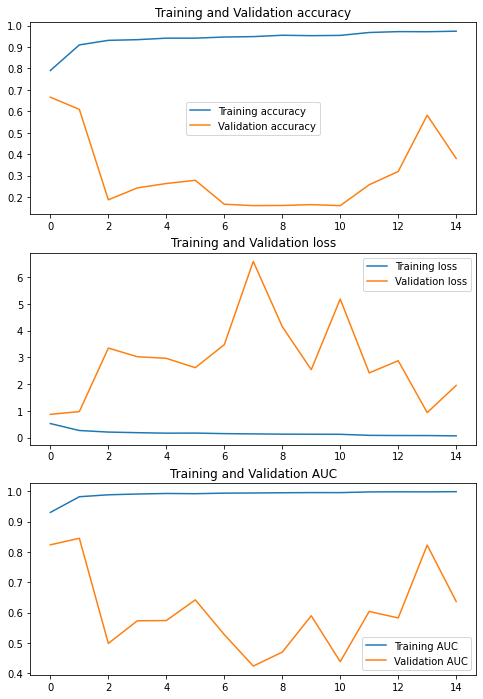

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

#### Fine-tune ChexNet

In [ ]:
for layer in chexnet_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [9]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune = chexnet_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                             callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 15/35
237/237 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9816 - AUC: 0.9990 - precision: 0.9824 - recall: 0.9810
Epoch 00015: val_loss improved from 0.86866 to 0.09176, saving model to ./weights/chexnet_3channel_scratch_d4.hdf5
End of epoch 14. Learning rate: 1e-04
237/237 [==============================] - 118s 455ms/step - loss: 0.0512 - accuracy: 0.9816 - AUC: 0.9990 - precision: 0.9824 - recall: 0.9810 - val_loss: 0.0918 - val_accuracy: 0.9703 - val_AUC: 0.9960 - val_precision: 0.9716 - val_recall: 0.9697 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 16/35
237/237 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9831 - AUC: 0.9991 - precision: 0.9844 - recall: 0.9827
Epoch 00016: val_loss did not improve from 0.09176
End of epoch 15. Learning rate: 1e-04
237/237 [==============================] - 103s 435ms/step - loss: 0.0460 - accuracy: 0.9831 - AUC: 0.9991 - precision: 0.9844 - reca

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']

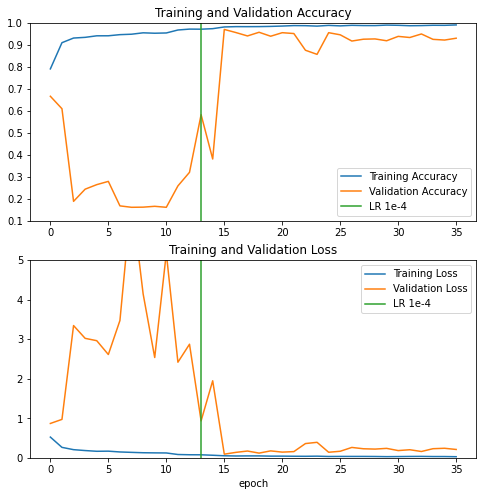

In [11]:
initial_epochs=history.epoch[-1]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='LR 1e-4')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='LR 1e-4')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
0,0.051244,0.981628,0.998980,0.982396,0.980967,0.091759,0.970342,0.996017,0.971576,0.969697,0.000100
3,0.047896,0.983214,0.998696,0.983596,0.982686,0.118695,0.957447,0.994698,0.958010,0.956157,0.000100
1,0.046048,0.983082,0.999115,0.984377,0.982686,0.137286,0.956157,0.993107,0.957364,0.955513,0.000100
9,0.033284,0.988766,0.999495,0.989281,0.988105,0.140156,0.955513,0.992271,0.955513,0.955513,0.000100
5,0.042279,0.985726,0.999113,0.986499,0.985065,0.143732,0.955513,0.992540,0.956072,0.954223,0.000100
6,0.039288,0.987840,0.999118,0.988097,0.987444,0.156556,0.951644,0.991399,0.952196,0.950355,0.000100
17,0.035837,0.987840,0.999221,0.988100,0.987708,0.159346,0.949710,0.991179,0.950936,0.949710,0.000032
10,0.034922,0.986519,0.999559,0.987169,0.986386,0.165462,0.945841,0.990440,0.946348,0.943907,0.000100
2,0.048086,0.982950,0.998777,0.983578,0.981628,0.171084,0.940683,0.990440,0.941138,0.938104,0.000100


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune2 = chexnet_model.fit(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                             callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 35/50
237/237 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9893 - AUC: 0.9996 - precision: 0.9896 - recall: 0.9890
Epoch 00035: val_loss did not improve from 0.09176
End of epoch 34. Learning rate: 1e-05
237/237 [==============================] - 120s 460ms/step - loss: 0.0306 - accuracy: 0.9893 - AUC: 0.9996 - precision: 0.9896 - recall: 0.9890 - val_loss: 0.1429 - val_accuracy: 0.9568 - val_AUC: 0.9935 - val_precision: 0.9580 - val_recall: 0.9568 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 36/50
237/237 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9893 - AUC: 0.9998 - precision: 0.9894 - recall: 0.9892
Epoch 00036: val_loss did not improve from 0.09176
End of epoch 35. Learning rate: 1e-05
237/237 [==============================] - 107s 452ms/step - loss: 0.0283 - accuracy: 0.9893 - AUC: 0.9998 - precision: 0.9894 - recall: 0.9892 - val_loss: 0.1431 - val_accuracy: 0.9568 - val_AUC: 

In [14]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
0,0.030603,0.989294,0.999550,0.989553,0.989030,0.142898,0.956802,0.993493,0.958037,0.956802,0.000010
1,0.028339,0.989294,0.999777,0.989424,0.989162,0.143052,0.956802,0.992728,0.956746,0.955513,0.000010
2,0.029029,0.989559,0.999761,0.990078,0.989162,0.144924,0.956157,0.992880,0.956157,0.956157,0.000010
3,0.027928,0.989030,0.999782,0.989024,0.988501,0.152302,0.951644,0.991989,0.951613,0.950999,0.000010
4,0.029800,0.989162,0.999468,0.989419,0.988766,0.156392,0.950355,0.991679,0.950936,0.949710,0.000010
5,0.028153,0.990748,0.999584,0.991006,0.990352,0.162957,0.947776,0.991417,0.948354,0.947131,0.000010
14,0.027978,0.990352,0.999713,0.991136,0.990219,0.168370,0.946486,0.990145,0.948287,0.945841,0.000003
8,0.026825,0.991277,0.999508,0.991537,0.991012,0.169746,0.941973,0.990652,0.943189,0.941973,0.000010
13,0.029984,0.989823,0.999313,0.990476,0.989691,0.171769,0.943907,0.990175,0.944444,0.942618,0.000003


### Model Evaluation

In [15]:
model = tf.keras.models.load_model('./weights/chexnet_3channel_scratch_d4.hdf5')

#### Montgomery County dataset

In [16]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)
res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [17]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.8889    1.0000    0.9412        16
          tb     1.0000    0.8333    0.9091        12

    accuracy                         0.9286        28
   macro avg     0.9444    0.9167    0.9251        28
weighted avg     0.9365    0.9286    0.9274        28



#### Shenzhen Evaluation

In [18]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [19]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.8553    0.9848    0.9155        66
          tb     0.9828    0.8382    0.9048        68

    accuracy                         0.9104       134
   macro avg     0.9190    0.9115    0.9101       134
weighted avg     0.9200    0.9104    0.9100       134



#### TBX11K dataset

In [20]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/val'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)
res = model.predict(test_generator)

Found 1551 images belonging to 3 classes.


In [22]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['health','sick','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      health     0.9771    0.9744    0.9757       702
        sick     0.9802    0.9883    0.9842       600
          tb     0.9268    0.9157    0.9212       249

    accuracy                         0.9703      1551
   macro avg     0.9614    0.9595    0.9604      1551
weighted avg     0.9702    0.9703    0.9703      1551

